In [1]:
'''
In this version the u_0 will be optimized and x_{k+1} will be viewed as controllable.
'''

'\nIn this version the u_0 will be optimized and x_{k+1} will be viewed as controllable.\n'

In [2]:
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import controller

In [3]:
ctrl = controller.controller()

In [4]:
Q = np.array(
    [
        [10,0,0,0],
        [0,10.,0,0],
        [0,0,0.,0],
        [0,0,0,0]
    ]
)

#R constructed by scale factor?
#R = 0.*np.eye(2) 
R = np.array([
    [1/2,0],[0,1/(0.2)]
])
F = np.array(
    [
        [30,0,0,0],
        [0,30.,0,0],
        [0,0,0.,0],
        [0,0,0,0]
    ]
)

ctrl.set_cost(Q,R,F)

In [5]:
CL = 4.5
ctrl.dt = 0.02
ctrl.pred_horizon = 60
ctrl.control_horizon = 4
''' 
x: x,y,theta,v 
u: T,delta

'''
def f(x,u):
    return np.array([
        [(np.cos(x[2])*x[3])[0]],
        [(np.sin(x[2])*x[3])[0]],
        [((np.tan(u[1])/CL)*x[3])[0]],
        [(0.5*u[0])[0]]
    ])

def matrix_iterator(x0,u0):
    A = np.array([
        [0,    0,  (-np.sin(x0[2])*x0[3])[0],   (np.cos(x0[2]))[0]],
        [0,    0,  (np.cos(x0[2])*x0[3])[0],    (np.sin(x0[2]))[0]],
        [0,    0,  0,                      (np.tan(u0[1])/CL)[0]],
        [0,0,0,0]
    ]
    )

    B = np.array(
        [
        [0,0],
        [0,0],
        [0, (x0[3]/(np.cos(u0[1])**2 * CL))[0]],
        [0.5,0]
        ]
    )

    '''f0 = np.array([
        [(np.cos(x0[2])*x0[3])[0]],
        [(np.sin(x0[2])*x0[3])[0]],
        [((np.tan(u0[1])/CL)*x0[3])[0]],
        [(0.5*u0[0])[0]]
    ])'''
    f0 = f(x0,u0)

    return A,B,f0

x0 = np.array(
    [
        [0],
        [3.],
        [0],
        [20]
    ]
)

xd = np.array(
    [
        [400],
        [0.],
        [0],
        [0]
    ]
)

u0 = np.array(
    [
        [0],
        [0]
    ]
)


In [6]:
#Throttle: -0.2*dt ~ 0.2*dt
A1 = np.zeros([ctrl.pred_horizon,2*ctrl.pred_horizon])
for i in range(ctrl.pred_horizon):
    A1[i,2*i] = 1.
    #A1[i,2*i+1] = 1.
b1 = np.zeros([ctrl.pred_horizon,1]) - 0.2*ctrl.dt

A2 = np.zeros([ctrl.pred_horizon,2*ctrl.pred_horizon])
for i in range(ctrl.pred_horizon):
    A2[i,2*i] = -1.
    #A2[i,2*i+1] = -1.
b2 = np.zeros([ctrl.pred_horizon,1]) - 0.2*ctrl.dt

#Steering: -pi/30 * dt ~ pi/30 * dt
A3 = np.zeros([ctrl.pred_horizon,2*ctrl.pred_horizon])
for i in range(ctrl.pred_horizon):
    A3[i,2*i+1] = 1.
b3 = np.zeros([ctrl.pred_horizon,1]) - np.pi/30 * ctrl.dt

A4 = np.zeros([ctrl.pred_horizon,2*ctrl.pred_horizon])
for i in range(ctrl.pred_horizon):
    A4[i,2*i+1] = -1.
b4 = np.zeros([ctrl.pred_horizon,1]) - np.pi/30 * ctrl.dt


A_const = np.vstack([A1,A2,A3,A4])
b_const = np.vstack([b1,b2,b3,b4]).reshape(-1)
print(A_const.shape,b_const.shape)

(240, 120) (240,)


In [7]:

xlist = [x0]
ulist = [u0]
ctrl.setup_model(f)
#ctrl.setup_constraints(A_const,b_const)
#u_old = u0
for i in range(300):
    A,B,f0 = matrix_iterator(x0,u0)
    ctrl.update_dynamics(A,x0,B,u0,f0)
    ctrl.discretize(ctrl.dt)

    #x0 = ctrl.apply_control(x0,u0) 
    #xlist.append(x0)
    ctrl.setup_qp_linear(x0,u0,xd)
    u = ctrl.solve_qp()
    
    for j in range(ctrl.control_horizon):
        u0 = u[2*j:2*j+2].reshape(-1,1)
        x0 = ctrl.apply_control(x0,u0) 
        ulist.append(u0)
        xlist.append(x0)

    #print('stepped')


In [8]:
import matplotlib.pyplot as plt

In [9]:
xm = np.array(xlist).squeeze(-1)
print(xm.shape)

(1201, 4)


In [10]:
u_tilde = np.array(ulist).reshape(-1,2)

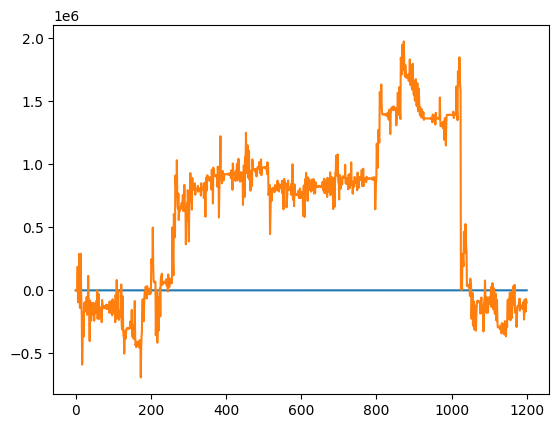

In [11]:
plt.plot(xm[:,0])
plt.plot(u_tilde[:,1]*1000)

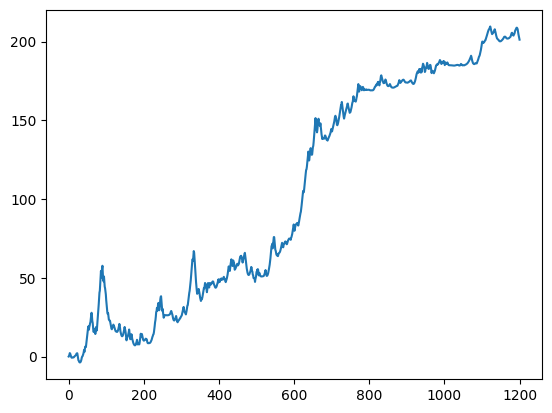

In [15]:
plt.plot(xm[:,0])

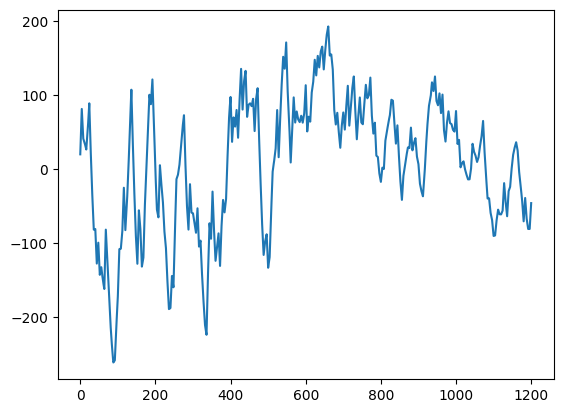

In [13]:
plt.plot(xm[:,3])

In [14]:
u_tilde[6,0]

-1020.9643109237351